## 로지스틱 회귀분석

### 관련 라이브러리 호출

In [1]:
# 관련 라이브러리를 호출합니다.
import os
import joblib
import numpy as np
import pandas as pd
from scipy import stats
import pingouin as pg

In [2]:
# 시각화 설정 모듈을 호출합니다.
from GraphicSetting import *

# EDA 시각화 및 통계 분석 관련 모듈을 호출합니다.
import hds_stats as hds

### 실습 데이터셋 준비

In [3]:
# 인터넷에 공유 중인 텍스트 데이터를 읽고 데이터프레임 df를 생성합니다.
df = pd.read_csv(filepath_or_buffer = 'https://bit.ly/UnivAdmit')

In [4]:
# df의 정보를 확인합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   1687 non-null   object 
 1   gre     1687 non-null   float64
 2   gpa     1687 non-null   float64
 3   rank    1687 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 52.8+ KB


In [5]:
# df의 처음 5행을 출력합니다.
df.head()

,admit,gre,gpa,rank
0,Fail,380.0,3.61,3
1,Pass,660.0,3.67,3
2,Pass,800.0,4.00,1
3,Pass,640.0,3.19,4
4,Fail,520.0,2.93,4


In [6]:
# y절편 역할을 수행할 상수 1을 df의 두 번째 열로 삽입합니다.
df.insert(loc = 1, column = 'const', value = 1)

### 실습 데이터셋 전처리

In [7]:
# rank를 범주형으로 변환합니다.
df['rank'] = df['rank'].astype(str)

In [8]:
# 연속형 변수의 기술통계량을 확인합니다.
df.describe()

,const,gre,gpa
count,1687.0,1687.000000,1687.000000
mean,1.0,574.303497,3.346183
std,0.0,97.923750,0.321537
min,1.0,220.000000,2.260000
25%,1.0,510.000000,3.130000
50%,1.0,580.000000,3.360000
75%,1.0,640.000000,3.580000
max,1.0,800.000000,4.000000


In [9]:
# 범주형 변수의 기술통계량을 확인합니다.
df.describe(include = object)

,admit,rank
count,1687,1687
unique,2,4
top,Fail,2
freq,1163,568


In [10]:
# rank의 범주별 빈도수를 출력합니다.
df['rank'].value_counts().sort_index()

rank
1    273
2    568
3    540
4    306
Name: count, dtype: int64

### 목표변수 시각화

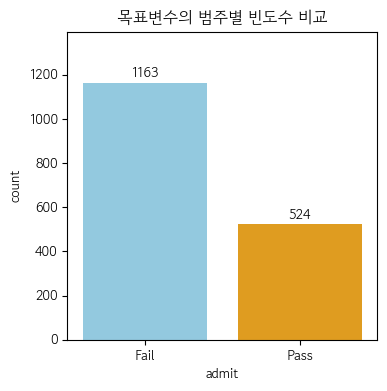

In [11]:
# 목표변수 범주별 빈도수로 일변량 막대 그래프를 그립니다.
hds.plot.bar_freq(
    data = df, 
    x = 'admit', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: gre

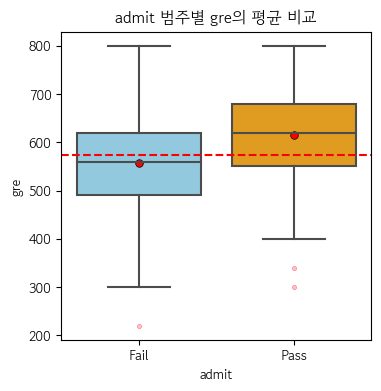

In [12]:
# admit 범주별 gre의 상자 수염 그림을 그립니다.
hds.plot.box_group(
    data = df, 
    x = 'admit', 
    y = 'gre', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: gpa

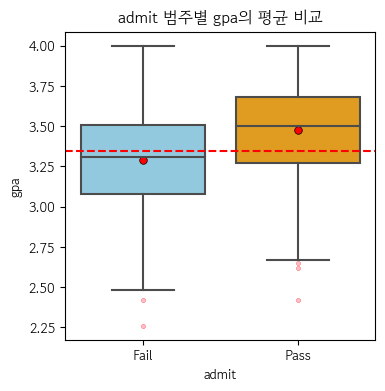

In [13]:
# admit 범주별 gpa의 상자 수염 그림을 그립니다.
hds.plot.box_group(
    data = df, 
    x = 'admit', 
    y = 'gpa', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: rank

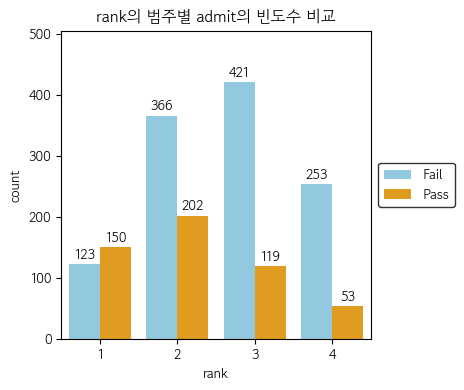

In [14]:
# rank 범주별 admit의 빈도수로 묶음 막대 그래프를 그립니다.
hds.plot.bar_dodge_freq(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
)

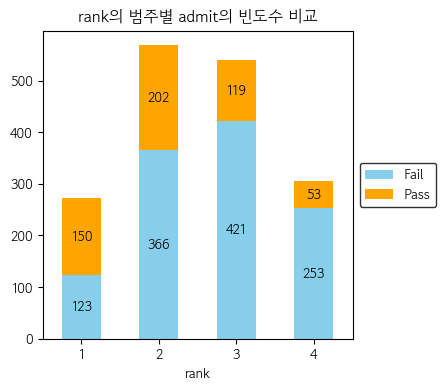

In [15]:
# rank 범주별 admit의 빈도수로 쌓은 막대 그래프를 그립니다.
hds.plot.bar_stack_freq(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
)

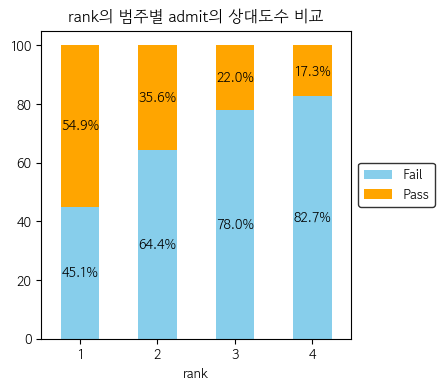

In [16]:
# rank 범주별 admit의 상대도수로 쌓은 막대 그래프를 그립니다.
hds.plot.bar_stack_prop(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
);

### t-검정: gre

In [17]:
pg.normality(data = df, dv = 'gre', group = 'admit')

,W,pval,normal
admit,,,
Fail,0.990862,0.000001,False
Pass,0.992275,0.008149,False


In [21]:
df.groupby(by = 'admit')['gre'].mean()

admit
Fail    556.079106
Pass    614.751908
Name: gre, dtype: float64

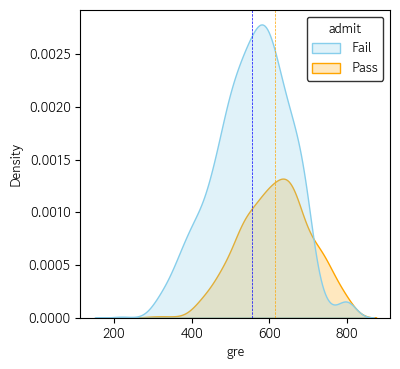

In [27]:
sns.kdeplot(data = df, x = 'gre', hue = 'admit', fill = True)
plt.axvline(x = 556.1, color = 'blue', lw = 0.5, ls = '--')
plt.axvline(x = 614.8, color = 'orange', lw = 0.5, ls = '--');

In [28]:
# (정규성 가정 만족) 등분산 검정을 실행합니다.
pg.homoscedasticity(data = df, dv = 'gre', group = 'admit')

,W,pval,equal_var
levene,3.596208,0.058082,True


In [29]:
# admit 범주별 gre로 시리즈를 생성합니다.
sp1 = df['gre'][df['admit'].eq('Fail')]
sp2 = df['gre'][df['admit'].eq('Pass')]

In [30]:
# (정규성 가정 만족) 등분산 가정된 독립표본 t-검정을 실행합니다.
pg.ttest(x = sp1, y = sp2, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.849448,1685,two-sided,3.604961e-31,"[-68.38, -48.96]",0.623448,6.726e+27,1.0


### t-검정 : gpa

In [31]:
pg.normality(data = df, dv = 'gpa', group = 'admit')

,W,pval,normal
admit,,,
Fail,0.993334,0.000044,False
Pass,0.984166,0.000018,False


In [32]:
df.groupby(by = 'admit')['gpa'].mean()

admit
Fail    3.287954
Pass    3.475420
Name: gpa, dtype: float64

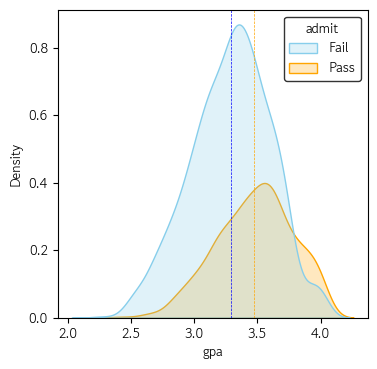

In [33]:
sns.kdeplot(data = df, x = 'gpa', hue = 'admit', fill = True)
plt.axvline(x = 3.287954, color = 'blue', lw = 0.5, ls = '--')
plt.axvline(x = 3.475420, color = 'orange', lw = 0.5, ls = '--');

In [34]:
# (정규성 가정 만족) 등분산 검정을 실행합니다.
pg.homoscedasticity(data = df, dv = 'gpa', group = 'admit')

,W,pval,equal_var
levene,0.678495,0.410222,True


In [35]:
# admit 범주별 gpa로 시리즈를 생성합니다.
sp1 = df['gpa'][df['admit'].eq('Fail')]
sp2 = df['gpa'][df['admit'].eq('Pass')]

In [36]:
# (정규성 가정 만족) 등분산 가정된 독립표본 t-검정을 실행합니다.
pg.ttest(x = sp1, y = sp2, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.50489,1685,two-sided,1.531444e-29,"[-0.22, -0.16]",0.605319,1.664e+26,1.0


### 교차분석: rank

In [37]:
# 범주형 입력변수 rank와 목표변수의 교차테이블을 출력합니다.
pd.crosstab(index = df['rank'], 
            columns = df['admit'], 
            margins = True, 
            margins_name = '합계', 
            normalize = 'index')

admit,Fail,Pass
rank,,
1,0.450549,0.549451
2,0.644366,0.355634
3,0.779630,0.220370
4,0.826797,0.173203
합계,0.689389,0.310611


In [38]:
# 교차테이블 빈도수로 교차분석(카이제곱 검정)을 실행합니다.
test = pg.chi2_independence(data = df, x = 'rank', y = 'admit')
test[2]

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,125.621299,3.0,4.748649e-27,0.272882,1.0
1,cressie-read,0.666667,124.433926,3.0,8.558048e-27,0.271589,1.0
2,log-likelihood,0.000000,123.670615,3.0,1.249714e-26,0.270755,1.0
3,freeman-tukey,-0.500000,124.456830,3.0,8.461367e-27,0.271614,1.0
4,mod-log-likelihood,-1.000000,126.396483,3.0,3.232631e-27,0.273722,1.0
5,neyman,-2.000000,133.872388,3.0,7.915429e-29,0.281701,1.0


### 더미변수 생성

In [39]:
df.head()

,admit,const,gre,gpa,rank
0,Fail,1,380.0,3.61,3
1,Pass,1,660.0,3.67,3
2,Pass,1,800.0,4.00,1
3,Pass,1,640.0,3.19,4
4,Fail,1,520.0,2.93,4


In [40]:
# 범주형 입력변수로 더미변수를 생성합니다.
df = pd.get_dummies(data = df, 
                    prefix = ['rank', None], 
                    columns = ['rank', 'admit'], 
                    drop_first = True, 
                    dtype = np.uint8)

In [41]:
# df의 처음 10행을 출력합니다.
df.head(n = 10)

,const,gre,gpa,rank_2,rank_3,rank_4,Pass
0,1,380.0,3.61,0,1,0,0
1,1,660.0,3.67,0,1,0,1
2,1,800.0,4.00,0,0,0,1
3,1,640.0,3.19,0,0,1,1
4,1,520.0,2.93,0,0,1,0
5,1,760.0,3.00,1,0,0,1
6,1,560.0,2.98,0,0,0,1
7,1,400.0,3.08,1,0,0,0
8,1,540.0,3.39,0,1,0,1
9,1,700.0,3.92,1,0,0,0


### 실습 데이터셋 분할

In [42]:
# 관련 라이브러리를 호출합니다.
from sklearn.model_selection import train_test_split

In [43]:
# 전체 데이터의 70%를 훈련셋, 30%를 검증셋으로 분할합니다.
train, valid = train_test_split(df, train_size = 0.7, random_state = 0, 
                                stratify = df['Pass'])

In [44]:
# 목표변수명을 변수에 할당합니다.
yvar = 'Pass'

### 입력변수와 목표변수 분리

In [45]:
# 훈련셋을 입력변수 행렬과 목표변수 벡터로 분리합니다.
trainX = train.drop(columns = [yvar])
trReal = train[yvar].copy()

In [46]:
# 훈련셋의 목표변수 범주별 상대도수를 확인합니다.
trReal.value_counts(normalize = True)

Pass
0    0.688983
1    0.311017
Name: proportion, dtype: float64

In [47]:
# 검증셋을 입력변수 행렬과 목표변수 벡터로 분리합니다.
validX = valid.drop(columns = [yvar])
vaReal = valid[yvar].copy()

In [48]:
# 검증셋의 목표변수 범주별 상대도수를 확인합니다.
vaReal.value_counts(normalize = True)

Pass
0    0.690335
1    0.309665
Name: proportion, dtype: float64

### 로지스틱 회귀모형 적합 및 결과 확인

In [49]:
??hds.stat.glm

In [50]:
# 훈련셋으로 로지스틱 회귀모형을 적합합니다.
fit1 = hds.stat.glm(y = trReal, X = trainX)

In [51]:
# fit1 모형의 적합 결과를 확인합니다.
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Pass   No. Observations:                 1180
Model:                            GLM   Df Residuals:                     1174
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -642.79
Date:                Thu, 25 May 2023   Deviance:                       1285.6
Time:                        15:17:02   Pearson chi2:                 1.19e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1396
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6439      0.822     -6.867      0.000      -7.255      -4.033
gre            0.0036      0.001      3.089      0.002       0.001       0.006
gpa            1.1031      0.347      3.177      0.001       0.423       1.784
rank_2        -0.7408      0.190     -3.899      0.000      -1.113      -0.368
rank_3        -1.3718      0.201     -6.823      0.000      -1.766      -0.978
rank_4        -1.7917      0.249     -7.206      0.000      -2.279      -1.304
==============================================================================
"""

### 로지스틱 회귀모형의 유의성 검정

In [52]:
# 두 모형의 이탈도 차이를 출력합니다.(검정통계량)
devGap = fit1.null_deviance - fit1.deviance
devGap

177.40741951219684

In [53]:
# 두 모형의 자유도 차이를 출력합니다.(카이제곱 분포의 자유도)
dofGap = fit1.df_model.copy()
dofGap

5

In [54]:
# 검정통계량과 자유도로 유의확률을 출력합니다.
1 - stats.chi2.cdf(x = devGap, df = dofGap)

0.0

### 다중공선성 확인

In [55]:
# 분산팽창지수를 출력하고 다중공선성 입력변수를 확인합니다.
hds.stat.vif(X = trainX)

,gre,gpa,rank_2,rank_3,rank_4
0,2.737893,2.7351,2.110802,2.090639,1.7885


### 오즈비 확인

In [56]:
fit1.params

const    -5.643940
gre       0.003554
gpa       1.103116
rank_2   -0.740847
rank_3   -1.371836
rank_4   -1.791702
dtype: float64

In [57]:
# 입력변수별 회귀계수의 오즈비를 출력합니다.
np.exp(fit1.params)

const     0.003539
gre       1.003561
gpa       3.013542
rank_2    0.476710
rank_3    0.253641
rank_4    0.166676
dtype: float64

### 표준화 회귀계수 확인

In [58]:
# fit1 모형의 회귀계수를 출력합니다.
fit1.params

const    -5.643940
gre       0.003554
gpa       1.103116
rank_2   -0.740847
rank_3   -1.371836
rank_4   -1.791702
dtype: float64

In [59]:
# 표준화 회귀계수를 생성합니다.
beta_z = hds.stat.std_coefs(model = fit1)
beta_z

const    -0.000000
gre       0.350900
gpa       0.360374
rank_2   -0.351684
rank_3   -0.640826
rank_4   -0.689399
dtype: float64

In [60]:
# 표준화 회귀계수의 절대값을 오름차순 정렬한 결과를 출력합니다.
beta_z.abs().sort_values()

const     0.000000
gre       0.350900
rank_2    0.351684
gpa       0.360374
rank_3    0.640826
rank_4    0.689399
dtype: float64

### 목표변수의 추정확률 생성

In [61]:
# 훈련셋으로 fit1 모형의 추정확률을 생성하고 실제값과 비교합니다.
trProb = fit1.predict(exog = trainX)
pd.DataFrame(data = {'Real': trReal, 'Prob': trProb})

,Real,Prob
714,0,0.350491
869,0,0.142222
667,0,0.042834
1260,0,0.045609
1559,0,0.302838
...,...,...
1106,0,0.211400
538,1,0.454211
104,1,0.578908
560,0,0.294922


In [62]:
# 검증셋으로 fit1 모형의 추정확률을 생성하고 실제값과 비교합니다.
vaProb = fit1.predict(exog = validX)
pd.DataFrame(data = {'Real': vaReal, 'Prob': vaProb})

,Real,Prob
1141,0,0.556953
1529,1,0.370885
501,0,0.474188
1046,0,0.074716
920,0,0.158329
...,...,...
493,0,0.251894
771,0,0.401326
827,0,0.158329
1432,1,0.651841


### 분류모형 성능 평가 : ROC 곡선

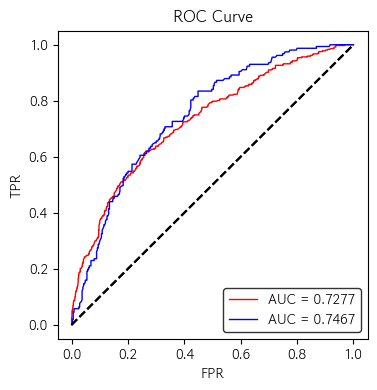

In [63]:
# 훈련셋과 검증셋의 추정확률로 ROC 곡선을 그립니다.
hds.stat.roc_curve(y_true = trReal, y_prob = trProb, color = 'red')
hds.stat.roc_curve(y_true = vaReal, y_prob = vaProb, color = 'blue')

### 목표변수의 추정값 생성

In [64]:
# 분리 기준점을 0.5로 설정합니다.
cutoff = 0.5

In [65]:
# 훈련셋의 목표변수 추정값(라벨)을 생성합니다.
trPred1 = np.where(trProb >= cutoff, 1, 0)

In [66]:
# 검증셋의 목표변수 추정값(라벨)을 생성합니다.
vaPred1 = np.where(vaProb >= cutoff, 1, 0)

### 분류모형 성능 평가 : 혼동행렬 리포트

In [67]:
# 훈련셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = trReal, y_pred = trPred1)

▶ Confusion Matrix
[[736  77]
 [252 115]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7449    0.9053    0.8173       813
           1     0.5990    0.3134    0.4114       367

    accuracy                         0.7212      1180
   macro avg     0.6719    0.6093    0.6144      1180
weighted avg     0.6995    0.7212    0.6911      1180



In [68]:
# 검증셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = vaReal, y_pred = vaPred1)

▶ Confusion Matrix
[[312  38]
 [105  52]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7482    0.8914    0.8136       350
           1     0.5778    0.3312    0.4211       157

    accuracy                         0.7179       507
   macro avg     0.6630    0.6113    0.6173       507
weighted avg     0.6954    0.7179    0.6920       507



### [참고] 혼동행렬 관련 함수

In [ ]:
# 관련 라이브러리를 호출합니다.
from sklearn import metrics

In [ ]:
# 검증셋 추정값으로 혼동행렬을 출력합니다.
print(metrics.confusion_matrix(y_true = vaReal, y_pred = vaPred1))

In [ ]:
# 검증셋 추정값으로 분류모형 리포트를 출력합니다.
print(metrics.classification_report(y_true = vaReal, y_pred = vaPred1))

In [ ]:
# 검증셋 추정값으로 F1 점수를 출력합니다.
metrics.f1_score(y_true = vaReal, y_pred = vaPred1, pos_label = 1)

### [참고] 목표변수의 범주별 추정확률 분포

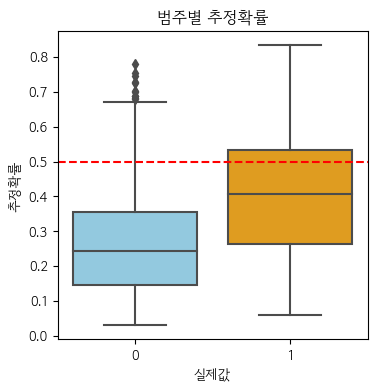

In [69]:
# 목표변수 범주별 추정확률 분포를 비교합니다.
sns.boxplot(x = trReal, y = trProb)
plt.title(label = '범주별 추정확률')
plt.xlabel(xlabel = '실제값')
plt.ylabel(ylabel = '추정확률')
plt.axhline(y = 0.5, color = 'red', lw = 1.5, ls = '--');

### [참고] 최적의 분리 기준점 탐색

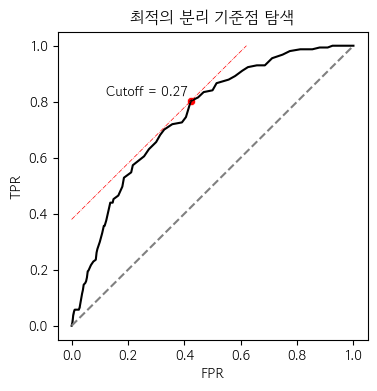

In [70]:
# 분리 기준점마다 민감도와 특이도를 계산하고 두 값의 합계가 최댓값일 때의 
# 분리 기준점을 ROC 곡선 위에 빨간 점으로 표시합니다.
hds.stat.EpiROC(y_true = vaReal, y_prob = vaProb)

### [참고] 최적의 분리 기준점으로 성능지표 확인

In [71]:
# 최적의 분리 기준점을 설정합니다.
cutoff = 0.27

In [72]:
# 분리 기준점 변경 후 검증셋의 목표변수 추정값(라벨)을 생성합니다.
vaPred2 = np.where(vaProb >= cutoff, 1, 0)

In [73]:
# 분리 기준점 변경 후 검증셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = vaReal, y_pred = vaPred2)

▶ Confusion Matrix
[[202 148]
 [ 31 126]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.8670    0.5771    0.6930       350
           1     0.4599    0.8025    0.5847       157

    accuracy                         0.6469       507
   macro avg     0.6634    0.6898    0.6388       507
weighted avg     0.7409    0.6469    0.6594       507



In [74]:
# 분리 기준점 변경 전 검증셋 추정값으로 혼동행렬 리포트와 비교합니다.
hds.stat.clfmetrics(y_true = vaReal, y_pred = vaPred1)

▶ Confusion Matrix
[[312  38]
 [105  52]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7482    0.8914    0.8136       350
           1     0.5778    0.3312    0.4211       157

    accuracy                         0.7179       507
   macro avg     0.6630    0.6113    0.6173       507
weighted avg     0.6954    0.7179    0.6920       507



### [참고] 매튜의 상관계수

In [77]:
from sklearn import metrics

In [78]:
# 분리 기준점 변경 전 검증셋 추정값으로 매튜의 상관계수를 출력합니다.
metrics.matthews_corrcoef(y_true = vaReal, y_pred = vaPred1)

0.26939860688985623

In [79]:
# 분리 기준점 변경 후 검증셋 추정값으로 매튜의 상관계수와 비교합니다.
metrics.matthews_corrcoef(y_true = vaReal, y_pred = vaPred2)

0.35225769077122454

### [참고] 최적의 분리 기준점 탐색 with MCC

In [80]:
# 분리 기준점 후보를 설정합니다.
cutoffs = np.linspace(start = 0, stop = 1, num = 100 + 1)

In [81]:
# 매튜의 상관계수를 저장할 빈 리스트를 생성합니다.
mccs = []

In [82]:
# for 반복문으로 분리 기준점 후보마다 매튜의 상관계수를 계산합니다.
for cutoff in cutoffs:
    vaPred = np.where(vaProb >= cutoff, 1, 0)
    mcc = metrics.matthews_corrcoef(y_true = vaReal, y_pred = vaPred)
    mccs.append(mcc)

In [83]:
# 최적의 분리 기준점을 반환합니다.
cutoffs[np.argmax(a = mccs)]

0.27

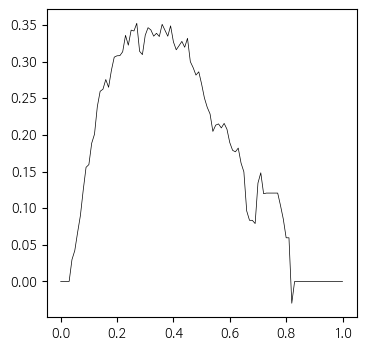

In [84]:
sns.lineplot(x = cutoffs, y = mccs, color = 'black', lw = 0.5);

## End of Document